[View in Colaboratory](https://colab.research.google.com/github/opooladz/ece_210_final_project/blob/master/210_final_project.ipynb)

In [8]:
# Import Libs 
import numpy as np
import numpy.matlib as npm
import matplotlib.pyplot as plt
import scipy.special
import scipy.io as sio
import math

# Reloading any code written in external .py files.
%load_ext autoreload
%autoreload 2

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, Flatten, AveragePooling2D, MaxPooling2D, Dropout, BatchNormalization
import keras
from sklearn import model_selection
from sklearn import svm
from keras.optimizers import Adam


Using TensorFlow backend.


In [0]:
# Comms Stuff Will add more later
def qammod1(m,width):
  #y = np.random.randint(m,size=(1,width)
  y = (np.arange(m)*np.ones((width,m))).T
  if(np.all(y>=m)):
    print('qammod: all elements of X must be in range [0,M-1]')
  
  if (~np.all(y == np.fix(y) ) ):
    print("qammod: all elements of X must be integers");
  
  c = np.sqrt(m);
  if( ~(np.all(c == np.fix(c)) and np.all(np.math.log(c, 2) == np.fix(np.math.log(c, 2))) ) ):
    print("qammod: M must be a square of a power of 2");
  
  b = -2*np.fmod(y,c) + c - 1.;
  a = 2*np.floor(y *1./c) - c + 1.;
  # x = a + 1.*1j*b
  # lets hold x in a np array([real,imag])
  x = np.array([a,1.*b]).transpose(2,1,0)
  return [x , y]
                        
# Comms Stuff Will add more later
def qammod2(m,size):
  y = np.random.randint(m,size=size)
  if(np.all(y>=m)):
    print('qammod: all elements of X must be in range [0,M-1]')
  
  if (~np.all(y == np.fix(y) ) ):
    print("qammod: all elements of X must be integers");
  
  c = np.sqrt(m);
  if( ~(np.all(c == np.fix(c)) and np.all(np.math.log(c, 2) == np.fix(np.math.log(c, 2))) ) ):
    print("qammod: M must be a square of a power of 2");
  
  b = -2*np.fmod(y,c) + c - 1.;
  a = 2*np.floor(y *1./c) - c + 1.;
  # x = a + 1.*1j*b
  # lets hold x in a np array([real,imag])
  x = np.array([a,1.*b]).transpose(2,1,0)
  return [x , y]                        

def channel(m,width,Noise,SNRdB):
  [x,y] = qammod2(m,width)
  
  SNR = 10**(SNRdB/10)
  sym_noise_pow = np.var(x)/SNR
  sym_noise_scale_fact = np.sqrt(sym_noise_pow)
  if(Noise):
    AWGN = sym_noise_scale_fact*np.random.normal( size=(width,m,2)) 
    x = x + AWGN
  return [x , y]
                        
def convChannel():
  h = [1, 0.5, 0.025]
  xh = np.convolve(x,h,'same') 
                        
data={}
def generateData(m,samples,Noise,SNRdB):
  [data['x_train'],data['y_train']] = channel(m=m,width=samples,Noise=Noise,SNRdB=SNRdB)
  #valsize = [int(x*0.1) for x in range(width)]
  [data['x_val'],data['y_val']] = channel(m=m,width=int(samples**0.5),Noise= Noise,SNRdB=SNRdB)
  [data['x_test'],data['y_test']] = channel(m=m,width=samples,Noise=Noise,SNRdB=SNRdB)

In [0]:
# Comms Stuff Will add more later
def qammod(m,y):
  if(np.all(y>=m)):
    print('qammod: all elements of X must be in range [0,M-1]')
  
  if (~np.all(y == np.fix(y) ) ):
    print("qammod: all elements of X must be integers");
  
  c = np.sqrt(m);
  if( ~(np.all(c == np.fix(c)) and np.all(np.math.log(c, 2) == np.fix(np.math.log(c, 2))) ) ):
    print("qammod: M must be a square of a power of 2");
  
  b = -2*np.fmod(y,c) + c - 1.;
  a = 2*np.floor(y *1./c) - c + 1.;
  # x = a + 1.*1j*b
  # lets hold x in a np array([real,imag])
  x = np.array([a,1.*b]).T
  return [x , y] 

def qammod2(m,size):
  y = np.random.randint(m,size=size)
  if(np.all(y>=m)):
    print('qammod: all elements of X must be in range [0,M-1]')
  
  if (~np.all(y == np.fix(y) ) ):
    print("qammod: all elements of X must be integers");
  
  c = np.sqrt(m);
  if( ~(np.all(c == np.fix(c)) and np.all(np.math.log(c, 2) == np.fix(np.math.log(c, 2))) ) ):
    print("qammod: M must be a square of a power of 2");
  
  b = -2*np.fmod(y,c) + c - 1.;
  a = 2*np.floor(y *1./c) - c + 1.;
  # x = a + 1.*1j*b
  # lets hold x in a np array([real,imag])
  x = np.array([a,1.*b]).T
  return [x , y]                        

def channel2(m,sequenceLen,trials,Noise,SNRdB):
  [x,y] = qammod2(m,sequenceLen)
  h = [1, 0.5]
  #h = [1]
  xh = np.convolve(x.flatten(),h)   
  SNR = 10**(SNRdB/10)
  sym_noise_pow = np.var(xh)/SNR
  sym_noise_scale_fact = np.sqrt(sym_noise_pow/2)
  if(Noise):
    AWGN = sym_noise_scale_fact*np.random.normal(1, size=(xh.shape[0],trials)) 
    xhN = xh[:,np.newaxis] + AWGN
  return [xhN.T , y]
                        
                        
data={}
def generateData2(m,sequenceLen,trials,Noise,SNRdB):
  [data['x_train'],data['y_train']] = channel2(m=m,sequenceLen=sequenceLen,trials=trials,Noise=Noise,SNRdB=SNRdB)
  #valsize = [int(x*0.1) for x in range(width)]
  #[data['x_val'],data['y_val']] = channel2(m=m,size=int(samples**0.5),Noise= Noise,SNRdB=SNRdB)
  [data['x_test'],data['y_test']] = channel2(m=m,sequenceLen=sequenceLen,trials=trials,Noise=Noise,SNRdB=SNRdB)

In [143]:
A = generateData2(4,64,100,1,20)

data['x_train']
print(data['y_train'])

[2 0 1 2 1 0 0 3 0 1 3 2 1 0 3 0 3 1 1 1 2 0 1 0 2 0 1 2 2 2 3 3 0 2 2 3 0
 1 3 2 0 0 3 0 3 2 3 2 2 0 3 0 3 3 1 1 3 0 3 0 1 3 1 0]


In [144]:
tmp= data['x_train']
tmp[0:10,0:10]

array([[ 1.03202424,  1.5371176 , -0.46672377,  0.47382587, -0.31738313,
        -1.38496467,  0.57843681,  1.64829299, -0.38121665, -1.51137683],
       [ 1.13397972,  1.57896129, -0.39157821,  0.77677365, -0.46340124,
        -1.48528519,  0.69754701,  1.55150498, -0.42193156, -1.46593442],
       [ 1.05379441,  1.60317942, -0.35873589,  0.51242454, -0.28415927,
        -1.55745808,  0.63880088,  1.62089989, -0.3851106 , -1.29701673],
       [ 1.1557272 ,  1.43150354, -0.50469052,  0.65065528, -0.39244406,
        -1.41482415,  0.72419538,  1.51406388, -0.3748633 , -1.39941172],
       [ 0.97318938,  1.61110567, -0.54694898,  0.50375614, -0.44947812,
        -1.47447552,  0.54045775,  1.59224794, -0.39256417, -1.50831326],
       [ 1.0911983 ,  1.40987394, -0.34850793,  0.65821792, -0.44799527,
        -1.43243463,  0.56205053,  1.60104893, -0.28815164, -1.36136457],
       [ 1.11324444,  1.79351014, -0.43444169,  0.57694688, -0.42630569,
        -1.40281537,  0.63170459,  1.51436061

In [147]:
tmp.shape

(100, 128)

In [0]:
K = tmp.reshape(100,64,2)


Text(0.5,1,'16-QAM Mod')

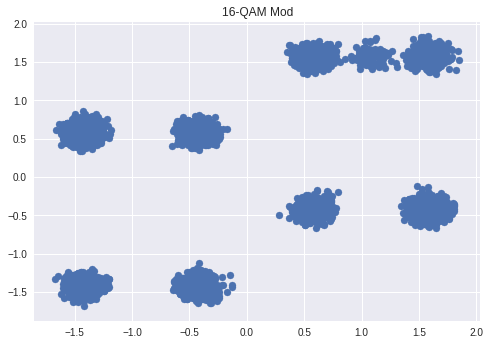

In [152]:
tmp2 = K.T
plt.scatter(tmp2[0],tmp2[1])
plt.title('16-QAM Mod')

In [0]:
qammod()

In [92]:
[xtmp,ytmp] = qammod2(16,size=(1,100))
x = xtmp.flatten()
h = [1, 0.5]
xh = np.convolve(x,h) 
A = xh[:,np.newaxis] + np.random.normal(1, size=(xh.shape[0],100)) 
A.shape

(201, 100)

In [0]:
# Keras try model 
def try_model(model, data, name, epochs=200, verbose=1):  
  model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

  model.summary()  
  history = model.fit(data['x_train'], data['y_train'], 
            epochs=epochs, batch_size=64, verbose=verbose, 
            validation_data=(data['x_val'], data['y_val']))  
  score = model.evaluate(data['x_test'], data['y_test'])
  print('Test accuracy: {}'.format(score))
  
#   out_path = 'serialized_models/{}.h5'.format(name)  
#   model.save(out_path)
  
#   with open('serialized_models/{}_history.pickle'.format(name), 'wb') as handle:
#     pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
  return history

In [61]:
# Generates 16-QAM model with AWGN
x = 6
square_power_of_two = 2**(2*x)
generateData(m=16,samples=square_power_of_two,Noise=1,SNRdB = 20)
print(data['x_train'].shape) # data
print(data['y_train'].shape) # labels 
# Our data is complex so I just made a len 2 list of real numbers.
# This way we can run it thought a conv net and keep spatial features
# Just so y'all can see the data  
print(data['x_train'][:,0,:])
print(data['x_val'].shape)

(4096, 16, 2)
(16, 4096)
[[-2.94207207  2.62872735]
 [-2.65008815  2.79981897]
 [-3.20773349  3.31114909]
 ...
 [-3.43732873  2.76809041]
 [-3.11831668  3.0461103 ]
 [-2.91861024  2.88337973]]
(64, 16, 2)


Text(0.5,1,'16-QAM Mod')

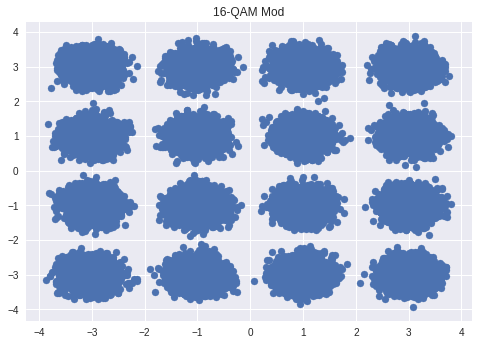

In [11]:
# Visulizing the data
# clearly we have 16 classes
# Right now this should be simple because I have not added any rayleigh fading 
# Lets get this to work and I'll keep updating the comms stuff
tmp = data['x_train'].T
plt.scatter(tmp[0],tmp[1])
plt.title('16-QAM Mod')

In [63]:
# Some more keras stuffs 
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, Flatten, AveragePooling2D, MaxPooling2D, Dropout, BatchNormalization
from keras.layers import Reshape, Permute
from keras import regularizers
import keras
ykeys = {'y_train','y_val','y_test'}
xkeys = {'x_train','x_val','x_test'}
datatmp={}
for i in ykeys:
  datatmp[i] = data[i].flatten()
for i in xkeys:
  datatmp[i] = data[i].reshape(-1,2)
  
y_train = keras.utils.to_categorical(datatmp['y_train'] , num_classes=16)
y_val = keras.utils.to_categorical(datatmp['y_val'] , num_classes=16)
y_test = keras.utils.to_categorical(datatmp['y_test'] , num_classes=16)

print(data['x_train'].shape)
print(y_train.shape)
print(data['x_val'].shape)


default_data = {
  'x_train': data['x_train'],
  'x_val': data['x_val'],
  'x_test': data['x_test'],
  'y_train': y_train,
  'y_val': y_val,
  'y_test': y_test,
}

(4096, 16, 2)
(65536, 16)
(64, 16, 2)


In [246]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Conv1D, Conv2D, Flatten, AveragePooling1D, MaxPooling2D, Dropout, BatchNormalization
from keras.layers import Reshape, Permute
from keras import regularizers
import keras

shallow_net = Sequential([
    Reshape(input_shape=(None,2), target_shape=(2,1)),
    Conv2D(filters = 40, kernel_size =(2,1), activation='elu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Flatten(),
    BatchNormalization(),    
    Dropout(rate=.7),
    Dense(16, activation='softmax', kernel_regularizer=regularizers.l2(0.01))
])

try_model(shallow_net, default_data, 'shallow_net', epochs=100)

ValueError: ignored

In [27]:
# create model
model = Sequential()
model.add(Dense(8, input_dim=2, activation='elu',kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(16, activation='softmax'))
try_model(model, default_data, 'shallow_net', epochs=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 8)                 24        
_________________________________________________________________
batch_normalization_2 (Batch (None, 8)                 32        
_________________________________________________________________
dense_16 (Dense)             (None, 16)                144       
Total params: 200
Trainable params: 184
Non-trainable params: 16
_________________________________________________________________
Train on 65536 samples, validate on 1024 samples
Epoch 1/200
46528/65536 [====================>.........] - ETA: 2s - loss: 2.8412 - acc: 0.0614

65536/65536 [==============================] - 9s 140us/step - loss: 2.8251 - acc: 0.0612 - val_loss: 2.7820 - val_acc: 0.0635
Epoch 2/200
65536/65536 [==============================] - 9s 136us/step - loss: 2.7796 - acc: 0.0601 - val_loss: 2.7766 - val_acc: 0.0605
Epoch 3/200
65536/65536 [==============================] - 9s 134us/step - loss: 2.7770 - acc: 0.0603 - val_loss: 2.7747 - val_acc: 0.0605
Epoch 4/200


65536/65536 [==============================] - 9s 133us/step - loss: 2.7760 - acc: 0.0607 - val_loss: 2.7748 - val_acc: 0.0654
Epoch 5/200
65536/65536 [==============================] - 9s 133us/step - loss: 2.7756 - acc: 0.0599 - val_loss: 2.7748 - val_acc: 0.0654
Epoch 6/200
57280/65536 [=========================>....] - ETA: 1s - loss: 2.7752 - acc: 0.0617

65536/65536 [==============================] - 9s 132us/step - loss: 2.7751 - acc: 0.0615 - val_loss: 2.7745 - val_acc: 0.0635
Epoch 7/200
65536/65536 [==============================] - 9s 134us/step - loss: 2.7753 - acc: 0.0604 - val_loss: 2.7742 - val_acc: 0.0615
Epoch 8/200
65536/65536 [==============================] - 9s 133us/step - loss: 2.7753 - acc: 0.0609 - val_loss: 2.7739 - val_acc: 0.0615
Epoch 9/200
 2624/65536 [>.............................] - ETA: 8s - loss: 2.7749 - acc: 0.0606

65536/65536 [==============================] - 9s 132us/step - loss: 2.7749 - acc: 0.0626 - val_loss: 2.7763 - val_acc: 0.0596
Epoch 10/200
65536/65536 [==============================] - 9s 133us/step - loss: 2.7749 - acc: 0.0590 - val_loss: 2.7745 - val_acc: 0.0605
Epoch 11/200
55488/65536 [========================>.....] - ETA: 1s - loss: 2.7746 - acc: 0.0627

65536/65536 [==============================] - 9s 134us/step - loss: 2.7747 - acc: 0.0619 - val_loss: 2.7739 - val_acc: 0.0596
Epoch 12/200
65536/65536 [==============================] - 9s 135us/step - loss: 2.7748 - acc: 0.0610 - val_loss: 2.7744 - val_acc: 0.0615
Epoch 13/200
65536/65536 [==============================] - 9s 134us/step - loss: 2.7747 - acc: 0.0616 - val_loss: 2.7743 - val_acc: 0.0625
Epoch 14/200
 1216/65536 [..............................] - ETA: 8s - loss: 2.7735 - acc: 0.0666

65536/65536 [==============================] - 9s 134us/step - loss: 2.7747 - acc: 0.0608 - val_loss: 2.7743 - val_acc: 0.0625
Epoch 15/200
65536/65536 [==============================] - 9s 135us/step - loss: 2.7746 - acc: 0.0613 - val_loss: 2.7741 - val_acc: 0.0596
Epoch 16/200
55360/65536 [========================>.....] - ETA: 1s - loss: 2.7745 - acc: 0.0629

65536/65536 [==============================] - 9s 134us/step - loss: 2.7745 - acc: 0.0625 - val_loss: 2.7741 - val_acc: 0.0635
Epoch 17/200
65536/65536 [==============================] - 9s 137us/step - loss: 2.7745 - acc: 0.0612 - val_loss: 2.7739 - val_acc: 0.0654
Epoch 18/200
64384/65536 [============================>.] - ETA: 0s - loss: 2.7745 - acc: 0.0621

65536/65536 [==============================] - 9s 137us/step - loss: 2.7745 - acc: 0.0620 - val_loss: 2.7739 - val_acc: 0.0615
Epoch 19/200
65536/65536 [==============================] - 9s 136us/step - loss: 2.7745 - acc: 0.0594 - val_loss: 2.7737 - val_acc: 0.0615
Epoch 20/200
65536/65536 [==============================] - 9s 134us/step - loss: 2.7744 - acc: 0.0607 - val_loss: 2.7736 - val_acc: 0.0605
Epoch 21/200
 1984/65536 [..............................] - ETA: 8s - loss: 2.7737 - acc: 0.0590

65536/65536 [==============================] - 9s 136us/step - loss: 2.7741 - acc: 0.0618 - val_loss: 2.7736 - val_acc: 0.0674
Epoch 22/200
65536/65536 [==============================] - 9s 134us/step - loss: 2.7742 - acc: 0.0617 - val_loss: 2.7736 - val_acc: 0.0654
Epoch 23/200
54656/65536 [========================>.....] - ETA: 1s - loss: 2.7740 - acc: 0.0633

65536/65536 [==============================] - 9s 133us/step - loss: 2.7740 - acc: 0.0632 - val_loss: 2.7737 - val_acc: 0.0654
Epoch 24/200
65536/65536 [==============================] - 9s 134us/step - loss: 2.7741 - acc: 0.0616 - val_loss: 2.7733 - val_acc: 0.0664
Epoch 25/200
65536/65536 [==============================] - 9s 134us/step - loss: 2.7742 - acc: 0.0608 - val_loss: 2.7737 - val_acc: 0.0625
Epoch 26/200
  896/65536 [..............................] - ETA: 9s - loss: 2.7715 - acc: 0.0725

65536/65536 [==============================] - 9s 132us/step - loss: 2.7741 - acc: 0.0609 - val_loss: 2.7734 - val_acc: 0.0654
Epoch 27/200
65536/65536 [==============================] - 9s 134us/step - loss: 2.7739 - acc: 0.0623 - val_loss: 2.7737 - val_acc: 0.0596
Epoch 28/200
55296/65536 [========================>.....] - ETA: 1s - loss: 2.7738 - acc: 0.0611

65536/65536 [==============================] - 9s 134us/step - loss: 2.7738 - acc: 0.0615 - val_loss: 2.7735 - val_acc: 0.0625
Epoch 29/200
65536/65536 [==============================] - 9s 135us/step - loss: 2.7738 - acc: 0.0606 - val_loss: 2.7736 - val_acc: 0.0635
Epoch 30/200
65536/65536 [==============================] - 9s 134us/step - loss: 2.7738 - acc: 0.0596 - val_loss: 2.7730 - val_acc: 0.0635
Epoch 31/200
  448/65536 [..............................] - ETA: 9s - loss: 2.7709 - acc: 0.0625 

65536/65536 [==============================] - 9s 135us/step - loss: 2.7737 - acc: 0.0620 - val_loss: 2.7735 - val_acc: 0.0566
Epoch 32/200
65536/65536 [==============================] - 9s 134us/step - loss: 2.7736 - acc: 0.0618 - val_loss: 2.7730 - val_acc: 0.0654
Epoch 33/200
56192/65536 [========================>.....] - ETA: 1s - loss: 2.7736 - acc: 0.0618

65536/65536 [==============================] - 9s 131us/step - loss: 2.7736 - acc: 0.0614 - val_loss: 2.7732 - val_acc: 0.0635
Epoch 34/200
65536/65536 [==============================] - 9s 135us/step - loss: 2.7736 - acc: 0.0613 - val_loss: 2.7733 - val_acc: 0.0664
Epoch 35/200
65536/65536 [==============================] - 9s 135us/step - loss: 2.7735 - acc: 0.0609 - val_loss: 2.7733 - val_acc: 0.0615
Epoch 36/200
  832/65536 [..............................] - ETA: 9s - loss: 2.7736 - acc: 0.0625

65536/65536 [==============================] - 9s 135us/step - loss: 2.7734 - acc: 0.0613 - val_loss: 2.7730 - val_acc: 0.0625
Epoch 37/200
65536/65536 [==============================] - 9s 133us/step - loss: 2.7734 - acc: 0.0614 - val_loss: 2.7730 - val_acc: 0.0684
Epoch 38/200
56384/65536 [========================>.....] - ETA: 1s - loss: 2.7733 - acc: 0.0612

65536/65536 [==============================] - 9s 132us/step - loss: 2.7733 - acc: 0.0611 - val_loss: 2.7730 - val_acc: 0.0615
Epoch 39/200
65536/65536 [==============================] - 9s 134us/step - loss: 2.7732 - acc: 0.0599 - val_loss: 2.7729 - val_acc: 0.0664
Epoch 40/200
65536/65536 [==============================] - 9s 134us/step - loss: 2.7732 - acc: 0.0609 - val_loss: 2.7728 - val_acc: 0.0615
Epoch 41/200
 1600/65536 [..............................] - ETA: 9s - loss: 2.7733 - acc: 0.0556

65536/65536 [==============================] - 9s 133us/step - loss: 2.7732 - acc: 0.0590 - val_loss: 2.7727 - val_acc: 0.0645
Epoch 42/200
65536/65536 [==============================] - 9s 136us/step - loss: 2.7731 - acc: 0.0622 - val_loss: 2.7727 - val_acc: 0.0625
Epoch 43/200
54656/65536 [========================>.....] - ETA: 1s - loss: 2.7730 - acc: 0.0593

65536/65536 [==============================] - 9s 134us/step - loss: 2.7730 - acc: 0.0596 - val_loss: 2.7728 - val_acc: 0.0625
Epoch 44/200
65536/65536 [==============================] - 9s 133us/step - loss: 2.7729 - acc: 0.0603 - val_loss: 2.7727 - val_acc: 0.0635
Epoch 45/200
65536/65536 [==============================] - 9s 134us/step - loss: 2.7729 - acc: 0.0615 - val_loss: 2.7726 - val_acc: 0.0625
Epoch 46/200
 1216/65536 [..............................] - ETA: 9s - loss: 2.7728 - acc: 0.0609

65536/65536 [==============================] - 9s 133us/step - loss: 2.7728 - acc: 0.0603 - val_loss: 2.7726 - val_acc: 0.0625
Epoch 47/200
65536/65536 [==============================] - 9s 133us/step - loss: 2.7728 - acc: 0.0615 - val_loss: 2.7727 - val_acc: 0.0625
Epoch 48/200
56704/65536 [========================>.....] - ETA: 1s - loss: 2.7728 - acc: 0.0615

65536/65536 [==============================] - 9s 133us/step - loss: 2.7728 - acc: 0.0608 - val_loss: 2.7726 - val_acc: 0.0625
Epoch 49/200
65536/65536 [==============================] - 9s 133us/step - loss: 2.7728 - acc: 0.0620 - val_loss: 2.7726 - val_acc: 0.0625
Epoch 50/200
65536/65536 [==============================] - 9s 134us/step - loss: 2.7728 - acc: 0.0614 - val_loss: 2.7727 - val_acc: 0.0635
Epoch 51/200
 2176/65536 [..............................] - ETA: 8s - loss: 2.7724 - acc: 0.0588

65536/65536 [==============================] - 9s 134us/step - loss: 2.7728 - acc: 0.0616 - val_loss: 2.7726 - val_acc: 0.0615
Epoch 52/200
65536/65536 [==============================] - 9s 135us/step - loss: 2.7728 - acc: 0.0601 - val_loss: 2.7727 - val_acc: 0.0625
Epoch 53/200
55232/65536 [========================>.....] - ETA: 1s - loss: 2.7728 - acc: 0.0614

65536/65536 [==============================] - 9s 134us/step - loss: 2.7728 - acc: 0.0612 - val_loss: 2.7727 - val_acc: 0.0625
Epoch 54/200
65536/65536 [==============================] - 9s 134us/step - loss: 2.7728 - acc: 0.0607 - val_loss: 2.7726 - val_acc: 0.0605
Epoch 55/200
65536/65536 [==============================] - 9s 134us/step - loss: 2.7728 - acc: 0.0610 - val_loss: 2.7726 - val_acc: 0.0625
Epoch 56/200
 1280/65536 [..............................] - ETA: 8s - loss: 2.7726 - acc: 0.0703

65536/65536 [==============================] - 9s 134us/step - loss: 2.7728 - acc: 0.0618 - val_loss: 2.7726 - val_acc: 0.0654
Epoch 57/200
65536/65536 [==============================] - 9s 133us/step - loss: 2.7728 - acc: 0.0607 - val_loss: 2.7726 - val_acc: 0.0605
Epoch 58/200
55296/65536 [========================>.....] - ETA: 1s - loss: 2.7728 - acc: 0.0625

65536/65536 [==============================] - 9s 135us/step - loss: 2.7728 - acc: 0.0622 - val_loss: 2.7727 - val_acc: 0.0596
Epoch 59/200
65536/65536 [==============================] - 9s 134us/step - loss: 2.7728 - acc: 0.0605 - val_loss: 2.7727 - val_acc: 0.0625
Epoch 60/200
65536/65536 [==============================] - 9s 132us/step - loss: 2.7728 - acc: 0.0610 - val_loss: 2.7727 - val_acc: 0.0625
Epoch 61/200
 2112/65536 [..............................] - ETA: 8s - loss: 2.7731 - acc: 0.0611

65536/65536 [==============================] - 9s 134us/step - loss: 2.7728 - acc: 0.0618 - val_loss: 2.7727 - val_acc: 0.0625
Epoch 62/200
65536/65536 [==============================] - 9s 134us/step - loss: 2.7727 - acc: 0.0642 - val_loss: 2.7727 - val_acc: 0.0625
Epoch 63/200
54976/65536 [========================>.....] - ETA: 1s - loss: 2.7729 - acc: 0.0587

65536/65536 [==============================] - 9s 136us/step - loss: 2.7729 - acc: 0.0588 - val_loss: 2.7726 - val_acc: 0.0625
Epoch 64/200
65536/65536 [==============================] - 9s 134us/step - loss: 2.7728 - acc: 0.0602 - val_loss: 2.7726 - val_acc: 0.0625
Epoch 65/200
65536/65536 [==============================] - 9s 136us/step - loss: 2.7728 - acc: 0.0609 - val_loss: 2.7726 - val_acc: 0.0625
Epoch 66/200


65536/65536 [==============================] - 9s 134us/step - loss: 2.7728 - acc: 0.0608 - val_loss: 2.7726 - val_acc: 0.0625
Epoch 67/200
65536/65536 [==============================] - 9s 134us/step - loss: 2.7728 - acc: 0.0632 - val_loss: 2.7727 - val_acc: 0.0625
Epoch 68/200
54976/65536 [========================>.....] - ETA: 1s - loss: 2.7728 - acc: 0.0603

65536/65536 [==============================] - 9s 134us/step - loss: 2.7728 - acc: 0.0609 - val_loss: 2.7727 - val_acc: 0.0625
Epoch 69/200
65536/65536 [==============================] - 9s 134us/step - loss: 2.7728 - acc: 0.0612 - val_loss: 2.7726 - val_acc: 0.0615
Epoch 70/200
65536/65536 [==============================] - 9s 135us/step - loss: 2.7728 - acc: 0.0612 - val_loss: 2.7726 - val_acc: 0.0625
Epoch 71/200
  832/65536 [..............................] - ETA: 9s - loss: 2.7727 - acc: 0.0493

65536/65536 [==============================] - 9s 134us/step - loss: 2.7728 - acc: 0.0619 - val_loss: 2.7727 - val_acc: 0.0625
Epoch 72/200
65536/65536 [==============================] - 9s 135us/step - loss: 2.7728 - acc: 0.0625 - val_loss: 2.7726 - val_acc: 0.0625
Epoch 73/200
55616/65536 [========================>.....] - ETA: 1s - loss: 2.7728 - acc: 0.0596

65536/65536 [==============================] - 9s 134us/step - loss: 2.7728 - acc: 0.0597 - val_loss: 2.7727 - val_acc: 0.0605
Epoch 74/200
65536/65536 [==============================] - 9s 141us/step - loss: 2.7728 - acc: 0.0596 - val_loss: 2.7726 - val_acc: 0.0625
Epoch 75/200
60864/65536 [==========================>...] - ETA: 0s - loss: 2.7728 - acc: 0.0611

65536/65536 [==============================] - 10s 146us/step - loss: 2.7728 - acc: 0.0614 - val_loss: 2.7726 - val_acc: 0.0625
Epoch 76/200
65536/65536 [==============================] - 9s 133us/step - loss: 2.7728 - acc: 0.0622 - val_loss: 2.7726 - val_acc: 0.0625
Epoch 77/200
65536/65536 [==============================] - 9s 133us/step - loss: 2.7728 - acc: 0.0603 - val_loss: 2.7726 - val_acc: 0.0625
Epoch 78/200
 2368/65536 [>.............................] - ETA: 8s - loss: 2.7727 - acc: 0.0570

65536/65536 [==============================] - 9s 132us/step - loss: 2.7728 - acc: 0.0608 - val_loss: 2.7726 - val_acc: 0.0635
Epoch 79/200
65536/65536 [==============================] - 9s 133us/step - loss: 2.7728 - acc: 0.0599 - val_loss: 2.7726 - val_acc: 0.0625
Epoch 80/200
56768/65536 [========================>.....] - ETA: 1s - loss: 2.7728 - acc: 0.0622

65536/65536 [==============================] - 9s 133us/step - loss: 2.7728 - acc: 0.0624 - val_loss: 2.7727 - val_acc: 0.0625
Epoch 81/200
65536/65536 [==============================] - 9s 132us/step - loss: 2.7728 - acc: 0.0622 - val_loss: 2.7727 - val_acc: 0.0615
Epoch 82/200
65536/65536 [==============================] - 9s 133us/step - loss: 2.7728 - acc: 0.0612 - val_loss: 2.7727 - val_acc: 0.0615
Epoch 83/200
 2432/65536 [>.............................] - ETA: 8s - loss: 2.7732 - acc: 0.0572

65536/65536 [==============================] - 9s 134us/step - loss: 2.7729 - acc: 0.0612 - val_loss: 2.7726 - val_acc: 0.0625
Epoch 84/200
65536/65536 [==============================] - 9s 134us/step - loss: 2.7728 - acc: 0.0607 - val_loss: 2.7726 - val_acc: 0.0635
Epoch 85/200
52864/65536 [=======================>......] - ETA: 1s - loss: 2.7728 - acc: 0.0626

65536/65536 [==============================] - 9s 141us/step - loss: 2.7728 - acc: 0.0617 - val_loss: 2.7726 - val_acc: 0.0625
Epoch 86/200
65536/65536 [==============================] - 9s 140us/step - loss: 2.7728 - acc: 0.0609 - val_loss: 2.7726 - val_acc: 0.0625
Epoch 87/200
 5888/65536 [=>............................] - ETA: 8s - loss: 2.7727 - acc: 0.0566

KeyboardInterrupt: ignored

In [185]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, Flatten, AveragePooling2D, MaxPooling2D, Dropout, BatchNormalization
from keras.layers import Reshape, Permute
from keras import regularizers
import keras

shallow_net = Sequential([
    Reshape(input_shape=(None,2), target_shape=(2,1)),    
    Conv1D(filters = 40, kernel_size =(1, 2), activation='elu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    AveragePooling2D(pool_size=(1, 75), strides=(1, 30)),  
    Flatten(),
    BatchNormalization(),
    Dropout(rate=.7),
    Dense(4, activation='softmax', kernel_regularizer=regularizers.l2(0.01))
])

try_model(shallow_net, data, 'shallow_net', epochs=100)

ValueError: ignored

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide


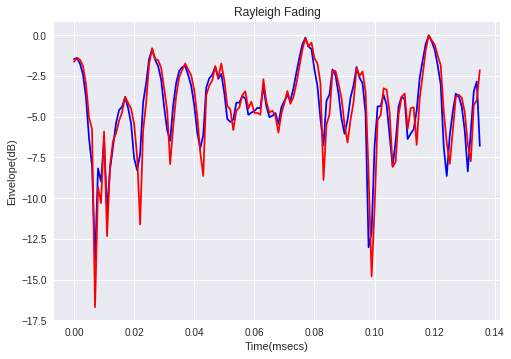

In [46]:
from numpy import sqrt
from numpy.random import randn
import numpy as np
import matplotlib.pyplot as plt

N=20;
fm=70.0;
df=(2*fm)/(N-1);
fs=1000;
M=round(fs/df);
T=1/df;
Ts=1/fs;       

h = [1, 0.5, 0.025]

# Generating first Gaussian RV set
g=randn(int(N/2))+1j*randn(int(N/2))
gc=np.conj(g)
gcr=gc[::-1]
g1=np.concatenate((gcr,g),axis=0)


# Generating second Gaussian RV set
g=randn(int(N/2))+1j*randn(int(N/2))
gc=np.conj(g)
gcr=gc[::-1]
g2=np.concatenate((gcr,g),axis=0)

# Generating the Doppler Spectrum
f=np.arange(-fm, fm+df, df)
S=1.5/(np.pi*fm*sqrt(1-(f/fm)**2))
S[0]=2*S[1]-S[2]
S[-1]=2*S[-2]-S[-3] 

# Shaping the RV sequence g1 and taking IFFT
X=g1*sqrt(S);
X=np.concatenate((np.zeros(int((M-N)/2)), X), axis=0)
X=np.concatenate((X, np.zeros(int((M-N)/2))), axis=0)
x=np.abs(np.fft.ifft(X))                             

# Shaping the RV sequence g2 and taking IFFT 
Y=g2*sqrt(S)
Y=np.concatenate((np.zeros(int((M-N)/2)), Y), axis=0)
Y=np.concatenate((Y, np.zeros(int((M-N)/2))), axis=0)
y=np.abs(np.fft.ifft(Y))

xh = np.convolve(x,h,'same') 
yh = np.convolve(y,h,'same')

# Generating Noise
AWGNr = np.random.normal(0,1,136)*0.001
AWGNi = np.random.normal(0,1,136)*0.001
AWGN = AWGNr + AWGNi

# Generating complex envelope
zh=xh+1j*yh
zhdirty = zh + AWGN
rh=np.abs(zhdirty)

z=x+1j*y
zdirty = z + AWGN
r=np.abs(zdirty)


# Plotting the envelope in the time domain 
t=np.arange(0, T, Ts)
plt.plot(t, 10*np.log10(rh/np.max(rh)),'b')
plt.plot(t, 10*np.log10(r/np.max(r)),'r')

plt.xlabel('Time(msecs)')
plt.ylabel('Envelope(dB)')
plt.grid(True)
plt.title('Rayleigh Fading')
plt.show()

In [55]:
data['x_train'].shape

(65536, 2)

In [58]:
xh = np.convolve(data['x_train'],h) 
yh = np.convolve(y,h,'same')

ValueError: ignored

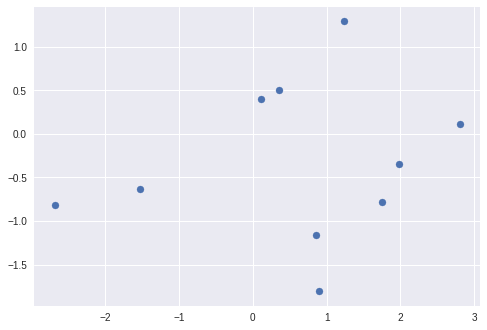

In [53]:
plt.scatter(g.real,g.imag)